<a href="https://colab.research.google.com/github/NGC55/work/blob/main/deep_image_matting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/foamliu/Deep-Image-Matting-PyTorch.git

Cloning into 'Deep-Image-Matting-PyTorch'...
remote: Enumerating objects: 3770, done.
remote: Total 3770 (delta 0), reused 0 (delta 0), pack-reused 3770
Receiving objects: 100% (3770/3770), 515.18 MiB | 38.86 MiB/s, done.
Resolving deltas: 100% (637/637), done.
Checking out files: 100% (1145/1145), done.


In [3]:
%cd /content/Deep-Image-Matting-PyTorch

/content/Deep-Image-Matting-PyTorch


In [4]:
pwd

'/content/Deep-Image-Matting-PyTorch'

In [13]:
# !wget --0 https://github.com/foamliu/Deep-Image-Matting-PyTorch/releases/download/v1.0/BEST_checkpoint.tar

wget: unrecognized option '--0'
Usage: wget [OPTION]... [URL]...

Try `wget --help' for more options.


In [37]:
!python extract.py

Extracting data/alphamatting/input_lowres.zip...
Extracting data/alphamatting/trimap_lowres.zip...


In [38]:
!python demo.py

/usr/local/lib/python3.7/dist-packages/torch/serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.parallel.data_parallel.DataParallel' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attri

In [51]:
import torch
from torchvision import transforms
from data_gen import data_transforms, gen_trimap, fg_test_files, bg_test_files
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [52]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

data_transforms = {
    'train': transforms.Compose([
        transforms.ColorJitter(brightness=0.125, contrast=0.125, saturation=0.125),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    'valid': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [69]:
img = cv2.imread("/content/drive/MyDrive/work/1803240710-00000140.jpg")

In [54]:
# マスク画像をerodeとdilateしてtrimapを作成
def gen_trimap(mask,k_size_e, k_size_d, ite_e,ite_d):
    kernel_e = np.ones(k_size_e,np.uint8)
    kernel_d = np.ones(k_size_d,np.uint8)
    eroded = cv2.erode(mask,kernel_e,iterations = ite_e)
    dilated = cv2.dilate(mask,kernel_d,iterations = ite_d)
    trimap = np.full((h,w), 128,  dtype=np.uint8)
    trimap[eroded == 255] = 255
    trimap[dilated == 0] = 0
    return trimap, eroded, dilated

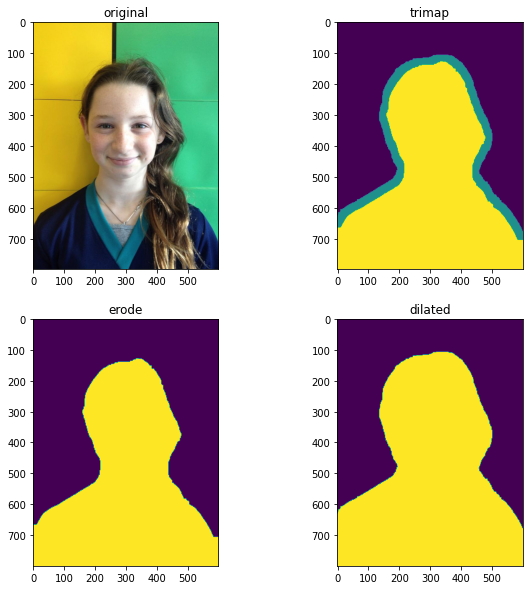

In [70]:
# マスク画像をerodeとdilateしてtrimapを作成
mask = cv2.imread("/content/drive/MyDrive/work/1803240710-00000140.png", cv2.IMREAD_UNCHANGED)
alpha = mask[:,:,3]
mask = mask[:,:,3]
np.place(mask, mask >0 , 255)
h, w = mask.shape
trimap, eroded, dilated = gen_trimap(mask,k_size_e=(3,3),k_size_d=(3,3), ite_e=10,  ite_d=10)
cv2.imwrite('/content/drive/MyDrive/work/trimap_test.png',trimap)
#plt.gray()
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.title('original')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

plt.subplot(2,2,2)
plt.title('trimap')
plt.imshow(trimap, vmin = 0, vmax = 255)

plt.subplot(2,2,3)
plt.title('erode')
plt.imshow(eroded)

plt.subplot(2,2,4)
plt.title('dilated')
plt.imshow(dilated)

/usr/local/lib/python3.7/dist-packages/torch/serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.parallel.data_parallel.DataParallel' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attri

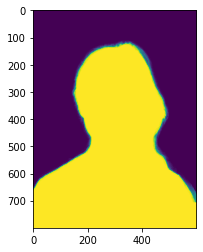

In [71]:
checkpoint = 'BEST_checkpoint.tar'
checkpoint = torch.load(checkpoint)
model = checkpoint['model'].module
model = model.to(device)
model.eval()



h, w = img.shape[:2]


x = torch.zeros((1, 4, h, w), dtype=torch.float)
image = img[..., ::-1]  # RGB
image = transforms.ToPILImage()(image)
image = transformer(image)
x[0:, 0:3, :, :] = image
x[0:, 3, :, :] = torch.from_numpy(trimap.copy() / 255.)

# Move to GPU, if available
x = x.type(torch.FloatTensor).to(device)
alpha = alpha / 255.

with torch.no_grad():
    pred = model(x)

pred = pred.cpu().numpy()
pred = pred.reshape((h, w))

pred[trimap == 0] = 0.0
pred[trimap == 255] = 1.0

# Calculate loss
# loss = criterion(alpha_out, alpha_label)

plt.imshow(pred)


In [72]:
def composite4(fg, bg, a, w, h):
    print(fg.shape, bg.shape, a.shape, w, h)
    fg = np.array(fg, np.float32)
    bg_h, bg_w = bg.shape[:2]
    x = 0
    if bg_w > w:
        x = np.random.randint(0, bg_w - w)
    y = 0
    if bg_h > h:
        y = np.random.randint(0, bg_h - h)
    bg = np.array(bg[y:y + h, x:x + w], np.float32)
    alpha = np.zeros((h, w, 1), np.float32)
    alpha[:, :, 0] = a
    im = alpha * fg + (1 - alpha) * bg
    im = im.astype(np.uint8)
    return im, bg


In [73]:
h,w,_ = img.shape
bg = np.full_like(img,255) 

im, bg = composite4(img, bg, pred, w, h)

(800, 600, 3) (800, 600, 3) (800, 600) 600 800


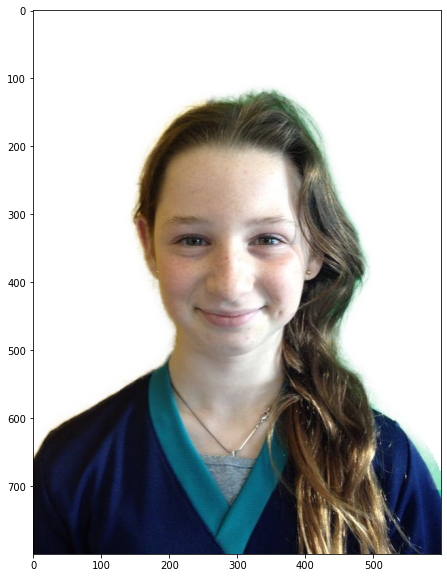

In [74]:
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.imshow(im)

In [64]:
pred.shape

(800, 600)